# Provenance Demo for roocs

Python PROV libray:
* https://prov.readthedocs.io/en/latest/index.html
* https://openprovenance.org/store/
* https://trungdong.github.io/prov-python-short-tutorial.html
* https://nbviewer.ipython.org/github/trungdong/notebooks/blob/master/PROV%20Tutorial.ipynb
* https://github.com/trungdong/prov/blob/master/src/prov/tests/examples.py

ESMValTool Provenance:
* https://github.com/ESMValGroup/ESMValCore/blob/master/esmvalcore/_provenance.py
* https://docs.esmvaltool.org/en/latest/community/diagnostic.html?highlight=provenance#recording-provenance
* https://esmvaltool.cloud.dkrz.de/shared/esmvaltool/v2.0.0/

In [1]:
from prov.model import ProvDocument

In [2]:
# Create a new provenance document
doc = ProvDocument()

## Namespaces

In [3]:
# Declaring namespaces for various prefixes used in the example
ROOCS_URI_PREFIX = 'https://roocs.org/'
doc.add_namespace('software', uri=ROOCS_URI_PREFIX + 'software')
doc.add_namespace('project', ROOCS_URI_PREFIX + 'project')  # copernicus, roocs
doc.add_namespace('workflow', ROOCS_URI_PREFIX + 'workflow')  # workflow description
doc.add_namespace('operator', ROOCS_URI_PREFIX + 'operator')  # task, job, calculation, algorithm
doc.add_namespace('parameter', ROOCS_URI_PREFIX + 'parameter') # operator parameter, option
doc.add_namespace('file', ROOCS_URI_PREFIX + 'file')  # netcdf, plots
doc.add_namespace('attribute', ROOCS_URI_PREFIX + 'attribute')  # netcdf attributes, headers variables

<Namespace: attribute {https://roocs.org/attribute}>

## Software

In [4]:
daops = doc.activity('software:daops==v0.2.0')

## Project

In [5]:
project_cds = doc.agent('project:Copernicus Climate Data Store')

## Datasets

In [6]:
attributes = {'attribute:variable': 'tas'}
ds_mpi = doc.entity('file:/data/cmip6/mpi_tas_2000-2010.nc', attributes)
ds_ipsl = doc.entity('file:/data/cmip6/ipsl_tas_2000-2010.nc', attributes)

## Operators

In [7]:
op_subset = doc.activity('operator:subset', other_attributes={'parameter:time': '2005'})
op_diff = doc.activity('operator:diff')

## Workflow

In [8]:
# Create workflow
wf_diff = doc.entity('workflow:diff.json')

# Relate workflow to project
doc.wasAttributedTo(wf_diff, project_cds)

<ProvAttribution: (workflow:diff.json, project:Copernicus Climate Data Store)>

## Run Subset Operator

In [9]:
# subset started by daops
doc.start(op_subset, starter=daops, trigger=wf_diff)

<ProvStart: (operator:subset, workflow:diff.json)>

In [10]:
# Generated output file for mpi dataet
output1 = doc.entity('file:mpi_tas_2005.nc', attributes)
doc.wasDerivedFrom(output1, ds_mpi, activity=op_subset)

<ProvDerivation: (file:mpi_tas_2005.nc, file:/data/cmip6/mpi_tas_2000-2010.nc)>

In [11]:
# Generated output file for ipsl dataset
output2 = doc.entity('file:ipsl_tas_2005.nc', attributes)
doc.wasDerivedFrom(output2, ds_ipsl, activity=op_subset)

<ProvDerivation: (file:ipsl_tas_2005.nc, file:/data/cmip6/ipsl_tas_2000-2010.nc)>

## Run Diff Operator

In [12]:
# diff started by daops
doc.start(op_diff, starter=daops, trigger=wf_diff)

<ProvStart: (operator:diff, workflow:diff.json)>

In [13]:
# Generated output
output_diff = doc.entity('file:diff_tas_2005.nc', attributes)
doc.wasDerivedFrom(output_diff, output1, activity=op_diff)
doc.wasDerivedFrom(output_diff, output2, activity=op_diff)

<ProvDerivation: (file:diff_tas_2005.nc, file:ipsl_tas_2005.nc)>

## Show Provenance

In [14]:
print(doc.get_provn())

document
  prefix software <https://roocs.org/software>
  prefix project <https://roocs.org/project>
  prefix workflow <https://roocs.org/workflow>
  prefix operator <https://roocs.org/operator>
  prefix parameter <https://roocs.org/parameter>
  prefix file <https://roocs.org/file>
  prefix attribute <https://roocs.org/attribute>
  
  activity(software:daops==v0.2.0, -, -)
  agent(project:Copernicus Climate Data Store)
  entity(file:/data/cmip6/mpi_tas_2000-2010.nc, [attribute:variable="tas"])
  entity(file:/data/cmip6/ipsl_tas_2000-2010.nc, [attribute:variable="tas"])
  activity(operator:subset, -, -, [parameter:time="2005"])
  activity(operator:diff, -, -)
  entity(workflow:diff.json)
  wasAttributedTo(workflow:diff.json, project:Copernicus Climate Data Store)
  wasStartedBy(operator:subset, workflow:diff.json, software:daops==v0.2.0, -)
  entity(file:mpi_tas_2005.nc, [attribute:variable="tas"])
  wasDerivedFrom(file:mpi_tas_2005.nc, file:/data/cmip6/mpi_tas_2000-2010.nc, operator:su

## Plot as png diagram

In [15]:
from prov.dot import prov_to_dot
figure = prov_to_dot(doc)
figure.write_png("roocs_demo_prov.png")

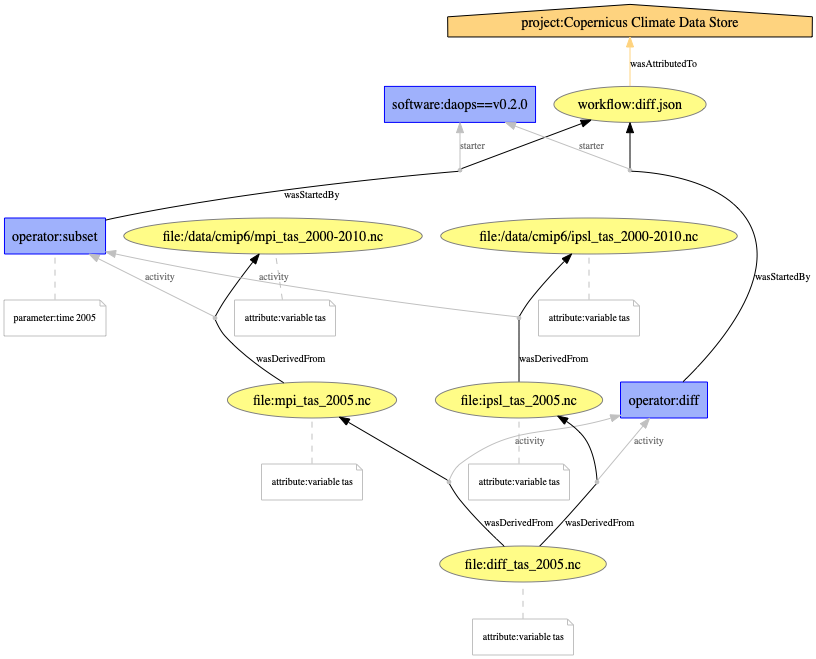

In [16]:
from IPython.display import Image
Image("roocs_demo_prov.png")